### INSTRUCTIONS :

#### The framework of the development was :
Python Version : 3.6.3
pandas : 0.22.0
matplotlib : 2.1.1
statsmodels : 0.8.0

#### Instructions  :
* Extract the content of the Zip File in a folder of choice.
* Certify that the excel file : **BLC Curve Historical.csv** and the Jupypter Notebbok File **CVA_IRS_HJM.ipynb** are in the same folder
* Initialise Juypter Noteebok and select the file **CVA\CVA_IRS_HJM.ipynb**
* You can run cell by cell by pressing **Shift + Enter**, it is important to run all cells in sequence
* Best option i go to the menu and select **Kernel >> Restart and Run All** 

In [1]:
#importing required libraries

import pandas as pd
import numpy as np
import copy as cp
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')# disabling warns

In [2]:
####Importing Historical Fwd Rates from csv., avaiable from 01/04/2005 to 31/10/2017 and adjusting the database ####
blc_curve_historical =  pd.read_csv('BLC Curve Historical.csv')
blc_curve_historical.dropna(inplace=True) #Eliminating Dates with no Data
blc_curve_historical['Date'] = pd.to_datetime(blc_curve_historical['Date']) #Converting first column to Date
blc_curve_historical = blc_curve_historical.set_index(['Date']) #Preparing Date column so it can be Indexed and used to Slice the Database
blc_curve_historical = blc_curve_historical/100 #Dividing rates by 100 to work as %

### Slicing Dataset
tenors = [float(x) for x in blc_curve_historical] #Extracting Tenors for use in Charts
crisis_hist = blc_curve_historical['20071001':'20091001'] #Slicing the last 2 Years
recent_rates_hist = blc_curve_historical['20151031':'20171031']

In [3]:
# Calculate the differences in rate per tenor
diff_rates_recent = np.diff(np.log(1+recent_rates_hist), axis=0)
assert(recent_rates_hist.shape[1]==diff_rates_recent.shape[1])

diff_rates_crisis = np.diff(crisis_hist, axis=0)
assert(recent_rates_hist.shape[1]==diff_rates_recent.shape[1])

In [4]:
# Calculate covariance matrices and re-annualise it with *252
sigma_recent = np.cov(diff_rates_recent.transpose())
sigma_recent *= 252

sigma_crisis = np.cov(diff_rates_crisis.transpose())
sigma_crisis *= 252

In [5]:
# Performe Eigen Decomposition
eigval_recent, eigvec_recent = np.linalg.eig(sigma_recent)
eigvec_recent=np.matrix(eigvec_recent)
assert type(eigval_recent) == np.ndarray
assert type(eigvec_recent) == np.matrix

eigval_crisis, eigvec_crisis = np.linalg.eig(sigma_crisis)
eigvec_crisis=np.matrix(eigvec_crisis)
assert type(eigval_crisis) == np.ndarray
assert type(eigvec_crisis) == np.matrix

In [6]:
# Extracting 3 main PCA from Eigen Decomposition
factors=3
princ_comp_recent = eigvec_recent[:,0:3].real   # highest principal component first in the array
princ_eigval_recent = eigval_recent[0:3].real

princ_comp_crisis = eigvec_crisis[:,0:3].real   # highest principal component first in the array
princ_eigval_crisis = eigval_crisis[0:3].real

In [7]:
sqrt_eigval_recent = np.matrix(princ_eigval_recent ** .5)
tmp_m = np.vstack([sqrt_eigval_recent for i in range(princ_comp_recent.shape[0])])  # resize matrix (1,factors) to (n, factors)
vols_recent = np.multiply(tmp_m, princ_comp_recent) # multiply matrice element-wise

sqrt_eigval_crisis = np.matrix(princ_eigval_crisis ** .5)
tmp_m = np.vstack([sqrt_eigval_crisis for i in range(princ_comp_crisis.shape[0])])  # resize matrix (1,factors) to (n, factors)
vols_crisis = np.multiply(tmp_m, princ_comp_crisis) # multiply matrice element-wise

In [8]:
def get_matrix_column(mat, i):
    return np.array(mat[:,i].flatten())[0]

class PolynomialInterpolator:
    def __init__(self, params):
        assert type(params) == np.ndarray
        self.params = params
    def calc(self, x):
        n = len(self.params)
        C = self.params
        X = np.array([x**i for i in reversed(range(n))])
        return sum(np.multiply(X, C))

In [9]:
def integrate(f, x0, x1, dx):
    n = (x1-x0)/dx+1
    out = 0
    for i, x in enumerate(np.linspace(x0, x1, n)):
        if i==0 or i==n-1:
            out += 0.5 * f(x)
        else:
            out += f(x)  # not adjusted by *0.5 because of repeating terms x1...xn-1 - see trapezoidal rule
    out *= dx
    return out

In [10]:
def m(tau, fitted_vols):
    #This funciton carries out integration for all principal factors. 
    #It uses the fact that volatility is function of time in HJM model
    out = 0.
    for fitted_vol in fitted_vols:
        assert isinstance(fitted_vol, PolynomialInterpolator)
        out += integrate(fitted_vol.calc, 0, tau, 0.01) * fitted_vol.calc(tau)
    return out

In [11]:
curve_spot = np.array(recent_rates_hist.tail(1))
curve_spot

array([[ 0.00423814,  0.00665423,  0.00882198,  0.01045977,  0.01110983,
         0.01160799,  0.01212793,  0.01268593,  0.0132592 ,  0.0138195 ,
         0.01435853,  0.01487381,  0.01536576,  0.01583518,  0.01628138,
         0.01670301,  0.01709748,  0.01746188,  0.01779329,  0.01808919,
         0.01834851,  0.01857087,  0.01875698,  0.01890786,  0.01902454,
         0.01910828,  0.01916136,  0.01918636,  0.01918584,  0.01916235,
         0.01911847,  0.01905648,  0.01897742,  0.01888202,  0.01877101,
         0.0186451 ,  0.01850502,  0.01835149,  0.01818523,  0.01800697,
         0.01781743,  0.01761733,  0.01740739,  0.01718834,  0.01696089,
         0.01672578,  0.01648371,  0.01623542,  0.01598163,  0.01572306,
         0.01546043]])

In [12]:
def vector_mc_sim(tenorsdif,total,time_step,drifts,vols):
    
    #This is a implementation of the MC Simulation as described on the class excel probably it is possible to vectorize the approach
    #and drastically improve the speed of the simulation but unfortunatelly i wasnt able to find a way.

    row,col = tenorsdif.shape
    total_steps = int(total/time_step)
    total_mc_size = np.zeros(shape=(total_steps+1,col))
    total_mc_size[0,:] = curve_spot
    rdn_numbers=np.random.randn(total_steps, 3)
    fittedvols_mult_rdnnumbers = np.dot(rdn_numbers[0:],vols)
    
    for n in range(1,total_steps+1):
        total_mc_size[n,:(col-1)]=total_mc_size[n-1,:(col-1)]+drifts[0,:(col-1)]*time_step+(fittedvols_mult_rdnnumbers[n-1,:(col-1)])*np.sqrt(time_step)+((np.matrix(total_mc_size[n-1,1:] - total_mc_size[n-1,:-1]))/(tenorsdif[0,:(col-1)]))*time_step
        total_mc_size[n,col-1]=total_mc_size[n-1,col-1]+drifts[0,col-1]*time_step+(fittedvols_mult_rdnnumbers[n-1,col-1])*np.sqrt(time_step)+((np.matrix(total_mc_size[n-1,col-1] - total_mc_size[n-1,col-2]))/(tenorsdif[0,col-1]))*time_step
        
    pd.DataFrame(rdn_numbers).to_csv("rdn_numbers.csv",sep=";")
    pd.DataFrame(total_mc_size).to_csv("total_mc_size.csv",sep=";")
    
    return total_mc_size

In [13]:
def extract_relevant_tenors(complete_matrix,maturity,dt):
    #This is a simple function that given the the dt and maturity of the IRS
    #it returns the relevant tenors for the precification
    x = 0
    relevant_tenors = np.zeros(shape=(size+1,size))
    for n in range(int(maturity/dt)+1):
        relevant_tenors[n]= complete_matrix[x,1:11]
        x += int(dt*100)
    return relevant_tenors


def fwd_rates_matrix(zero_rates_matrix,dt):
    #function that get the spot rates and calculate forwards
    fwd_rates = np.zeros(shape=zero_rates_matrix.shape)
    fwd_rates[:,0] = zero_rates_matrix[:,0]
    dti = dt
    dtf = 2*dt
    nrow,ncol = zero_rates_matrix.shape
    for n in range(1,ncol):
        fwd_rates[:,n] = (zero_rates_matrix[:,n]*dtf-zero_rates_matrix[:,n-1]*dti)/dt
        dti=dtf
        dtf=dtf+dt
    return fwd_rates

def disc_factors_matrix(rates_matrix,dt):
    #Calculates the discount facotrs given a matrix of forward rates
    disc_factors = np.zeros(shape=rates_matrix.shape)
    disc_factors[:,0] = 1/(1+rates_matrix[:,0]*dt)
    nrow,ncol = rates_matrix.shape
    for n in range(1,ncol):
        disc_factors[:,n] = 1/(1+rates_matrix[:,n]*dt)* disc_factors[:,n-1]
    return disc_factors

def irs_exposure_profile(fixed_leg,maturity,dt,notional,zero_rates):
    #Preficication of each tenor of the IRS
    fwd_rates_curve = fwd_rates_matrix(zero_rates,dt)
    discount_matrix = disc_factors_matrix(fwd_rates_curve,dt)
    exposures_matrix = np.zeros(shape=(int(maturity/dt)+1,int(maturity/dt)))
    nrow,ncol = zero_rates.shape
    for n in range(0,ncol):
        exposures_matrix[n,n:] = (fwd_rates_curve[n,:(size-n)]-pay_leg)*notional*dt*discount_matrix[n,:(size-n)]
    return exposures_matrix

def exposure_profiles(disc_cashflows):
    #Calculation of the exposure profile of the IRS
    nrow,ncol = disc_cashflows.shape
    exp_profiles = np.zeros(shape=(nrow,1))
    exp_profiles = np.maximum(0,disc_cashflows.sum(axis=1))
    return exp_profiles
        

# Chapter 1 - CVA Calculation for an Interest Rate Swap using HJM Model
#### A comparison of the CVA final value based on the initial selection of the forward rates historical period used as input in the HJM model

### Introduction
In this chapter we demonstrate an example of a CVA calculation for a single Interest Rate Swap using the output of an HJM model used to project the whole forward rate curve. In order to understand the effect on the model and on the CVA calculation of the initial selection of the historical period used in the HJM model, two different rates regimes were selected:

1) From 10/31/2015 to 10/31/2017 - Which is referred throughout this chapter as **_"recent data"_** which represents a low rate low volatility rates regime

2) From 10/01/2007 to 10/01/2009 - Which is referred throughout this chapter as **_"crisis data"_** which represents a higher rates higher volatility rates regime

The main objective is to understand how the data selection affects the goodness of fit statistic for the k-factor model ($Cum. R^2$) for the Principal Component Analysis (PCA) and how the different rates regime affects the final value of the CVA for the same derivative contract (Interest Rate Swap (IRS) for this example). For this purpose, we are presenting results for each main step of the HJM model as well as for the CVA calculation.

The implementation was made in Python 3.6.3 using Jupyter Notebook, explanation of the code is not in scope of this chapter, please refer to the Python Notebook CVA_IRS-HJM.ipynb for a commented version of the code implementation

### Brief Introduction of Main Concepts

#### The CVA measure for Counterparty Credit Risk
Any exposure to OTC derivatives produces counterpart credit risk (CCR) which is defined as the risk that a counterpart potentially fails to meet its obligations including the non-payment of future cash flows that were agreed on derivatives contracts. The modelling of the potential future exposure that may arise from these contracts becomes a fundamental part of the risk management and need to be considered when pricing those instruments.


Credit Value Adjustment (CVA) is an adjustment to the fair value (or price) of derivative instruments to account for CCR. Thus, CVA is commonly viewed as the price of CCR. This price depends on counterparty credit spreads as well as on the market risk factors that drive derivatives’ values and, therefore, exposure.

#### The CVA formula is : $$ CVA = (1-R)\int_{0}^{T} EE_{t}\,DF_{t}\,dPD_{t}\, $$

Where : 

$R$ is the Recovery Rate

$EE_{t}$ is the Expected Exposure at time ${t}$

$DF_{t}$ is the Discount Factor at time ${t}$

$dPD_{t}$ is the default probability distribution at time ${t}$

CVA is a "charge" or "adjustment" that is applied to the price of a financial instruments so that counterpart credit risk is taken into account.

$$\Pi^{*} = \Pi - CVA$$

Where : 

$\Pi^{*}$ is the Corrected price

$\Pi$ is the fair value (or price)

$CVA$ is "charge" due to CCR

#### The Heath, Jarrow & Morton (HJM) forward rate model
HJM is a quite general framework for the modeling of interest-rate dynamics and its approach to modeling of the forward curve was a breakthrough that improved pricing and risk management in fixed income. As an alternative to deriving forward rates from modelled short-term ones, they started with a model for the whole forward rate curve. 

It uses real historical data of the movement of the forward rates curve and incorporate them into the pricing methodology, which makes the fitting to a market yield curve a natural process within the HJM.

Starting with the forward rate equation $f(t,T) = -\frac{\partial}{\partial T} lnZ(t,T)$ and using the bond price "GBM" SDE to derive the evolution of forward rates, we come at :

$$ dF(t;T) = \frac{\partial}{\partial T} \,(\frac{1}{2} \sigma^2(t,T) - \mu(t,T))\,dt - \frac{\partial}{\partial T}\sigma(t,T)dX$$

Which is the Stochastic Differential Equation (SDE) for a forward curve. The SDE carries the drift of the bond price $\mu(t,T)$.

### HJM Model Implementation and Analysis of Results

#### Data Preparation

For this implementation of the Heath, Jarrow & Morton forward rate model we use as initial data the daily forward rates from the Government Liability Curve (GLC) data provided by the Bank of England found at https://www.bankofengland.co.uk/statistics/yield-curves. For this data set we have daily rates beginning at January 04, 2005 until October 31, 2017. The available tenors for the set are:

In [14]:
pd.options.display.max_rows = 10
pd.options.display.max_columns = 14
tenors_dtf = pd.DataFrame(tenors)
display(tenors_dtf.transpose())

,0,1,2,3,4,5,6,...,44,45,46,47,48,49,50
0,0.08,0.5,1.0,1.5,2.0,2.5,3.0,...,22.0,22.5,23.0,23.5,24.0,24.5,25.0


To understand the effect of different rates regimes in the exercise final output the model will be applied for two selections of initial data, October 2015 to October 2017 representing a low rate regime and 2007 to 2008 representing a severe crisis (Sub-Prime Crisis).

**Chart 1** and **Chart 2** represents the periods Average Rates and Standard Deviations, it is possible to visualize the 2 different rates regimes, most recent data average rates reflects the low rates regimes from the last years with a stable standard deviations, while during the financial crisis rates were at higher levels and with higher volatilities especially in the lower end of the curve.

In [15]:
mean_recent = np.mean(recent_rates_hist, axis=0)
std_recent = np.std(recent_rates_hist, axis=0)
mean_crisis = np.mean(crisis_hist, axis=0)
std_crisis = np.std(crisis_hist, axis=0)

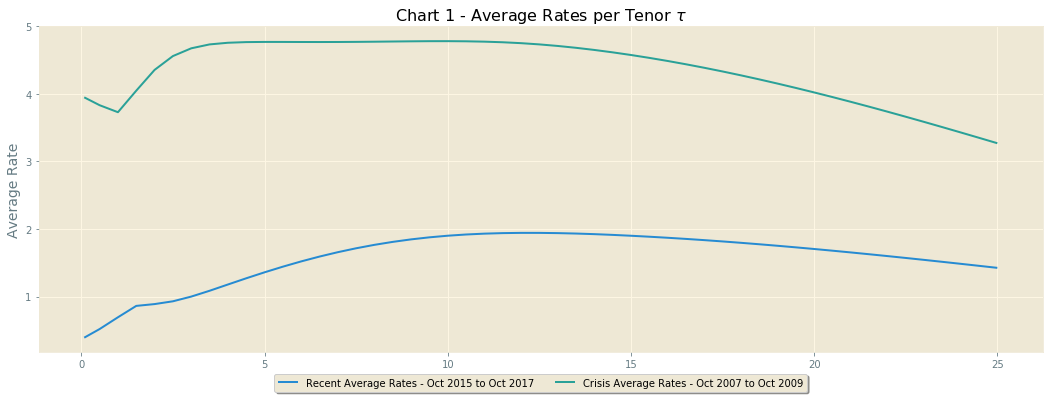

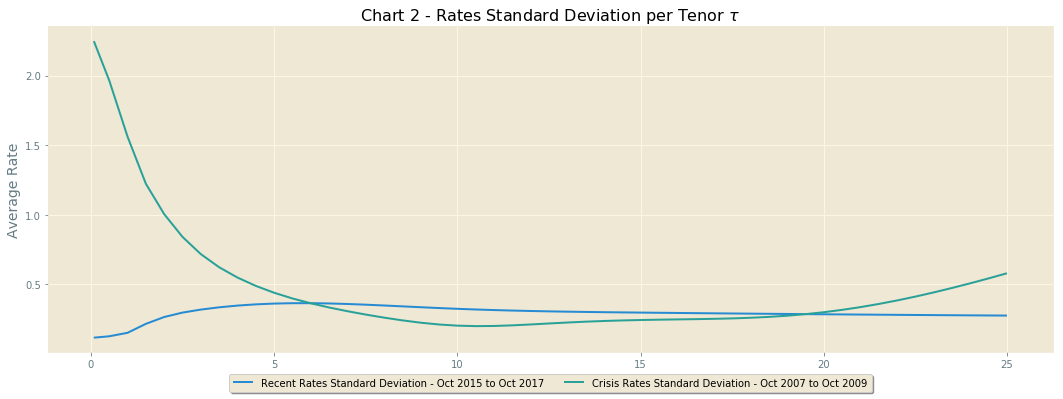

In [16]:
plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(tenors, mean_recent*100,label='Recent Average Rates - Oct 2015 to Oct 2017')
    plt.plot(tenors, mean_crisis*100,label='Crisis Average Rates - Oct 2007 to Oct 2009')
    # Number of accent colors in the color scheme
    plt.title(r'Chart 1 - Average Rates per Tenor $\tau$')
    plt.xlabel(r'Tenor $\tau$', fontsize=14)
    plt.ylabel('Average Rate', fontsize=14)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

plt.figure(figsize=(18,6))    
with plt.style.context('Solarize_Light2'):
    plt.plot(tenors, std_recent*100,label='Recent Rates Standard Deviation - Oct 2015 to Oct 2017')
    plt.plot(tenors, std_crisis*100,label='Crisis Rates Standard Deviation - Oct 2007 to Oct 2009')
    # Number of accent colors in the color scheme
    plt.title(r'Chart 2 - Rates Standard Deviation per Tenor $\tau$')
    plt.xlabel(r'Tenor $\tau$', fontsize=14)
    plt.ylabel('Average Rate', fontsize=14)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

A graphic representation of the evolution of selected Tenors($\tau$) (0.08, 0.5, 1, 5, 10, 15, 20 and 25) by the time is presented bellow on charts 3 and 4. Here it is also possible to visualize the different behaviors of the tenors on each rate regime. Short term rates (0.08 and 0.5) presents a more stable development on the last 2 years when compared to the crisis period.

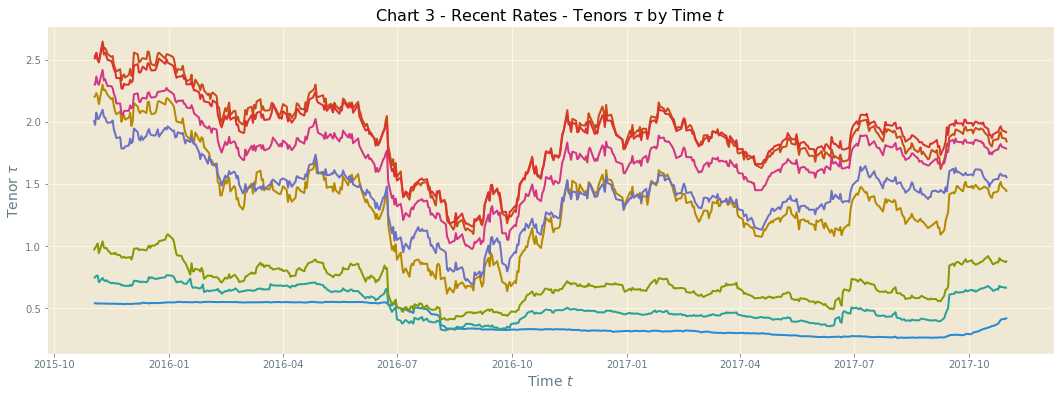

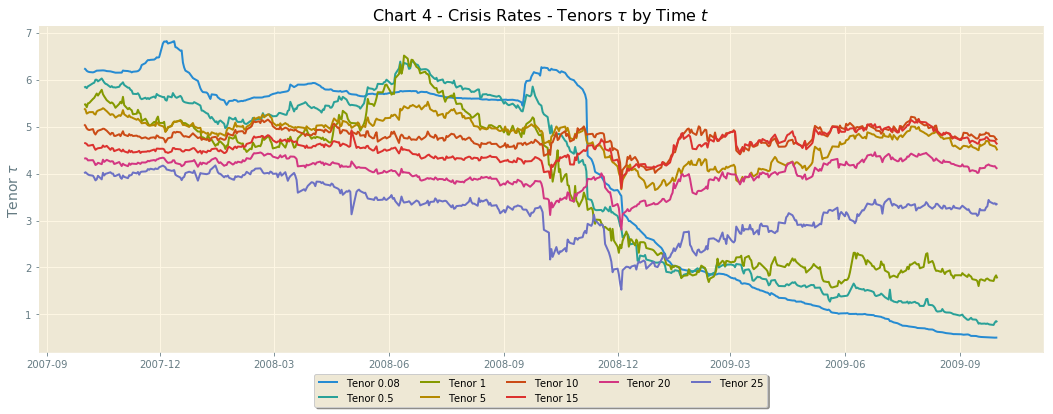

In [17]:
plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(recent_rates_hist[['0.08']]*100,label='Tenor 0.08')
    plt.plot(recent_rates_hist[['0.5']]*100,label='Tenor 0.5')
    plt.plot(recent_rates_hist[['1']]*100,label='Tenor 1')
    plt.plot(recent_rates_hist[['5']]*100,label='Tenor 5')
    plt.plot(recent_rates_hist[['10']]*100,label='Tenor 10')
    plt.plot(recent_rates_hist[['15']]*100,label='Tenor 15')
    plt.plot(recent_rates_hist[['20']]*100,label='Tenor 20')
    plt.plot(recent_rates_hist[['25']]*100,label='Tenor 25')
    # Number of accent colors in the color scheme
    plt.title(r'Chart 3 - Recent Rates - Tenors $\tau$ by Time $t$')
    plt.xlabel(r'Time $t$', fontsize=14)
    plt.ylabel(r'Tenor $\tau$', fontsize=14)

plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(crisis_hist[['0.08']]*100,label='Tenor 0.08')
    plt.plot(crisis_hist[['0.5']]*100,label='Tenor 0.5')
    plt.plot(crisis_hist[['1']]*100,label='Tenor 1')
    plt.plot(crisis_hist[['5']]*100,label='Tenor 5')
    plt.plot(crisis_hist[['10']]*100,label='Tenor 10')
    plt.plot(crisis_hist[['15']]*100,label='Tenor 15')
    plt.plot(crisis_hist[['20']]*100,label='Tenor 20')
    plt.plot(crisis_hist[['25']]*100,label='Tenor 25')
    # Number of accent colors in the color scheme
    plt.title(r'Chart 4 - Crisis Rates - Tenors $\tau$ by Time $t$')
    plt.xlabel(r'Time $t$', fontsize=14)
    plt.ylabel(r'Tenor $\tau$', fontsize=14)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

#### Covariance Matrix Estimation
To estimate the covariance matrix, we need to obtain daily differences rates for each tenor. For low rates regime it is best to conduct the Principal Component Analysis (PCA) on log-differences in forward rates: $log \, f(t + \Delta t) - logf(t)$ for each tenor. We applied log differences for the most recent data series and differences for the crises data series. Chart 5 and 6 shows the results.  

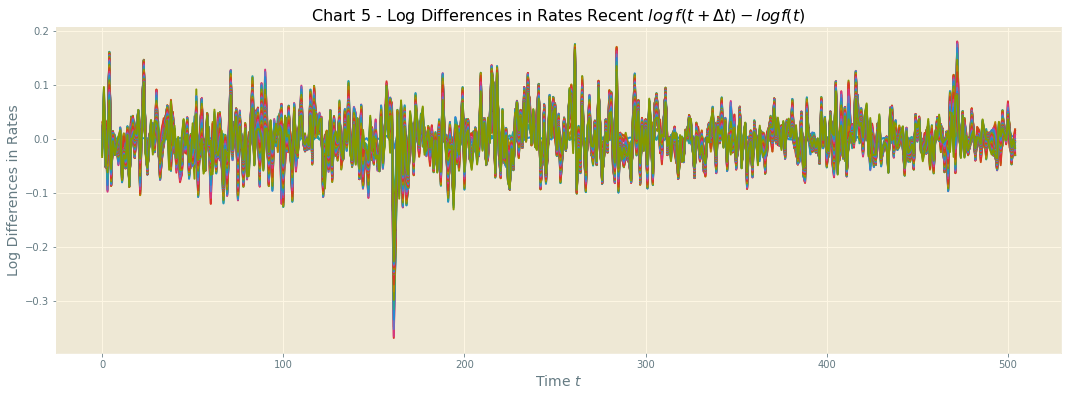

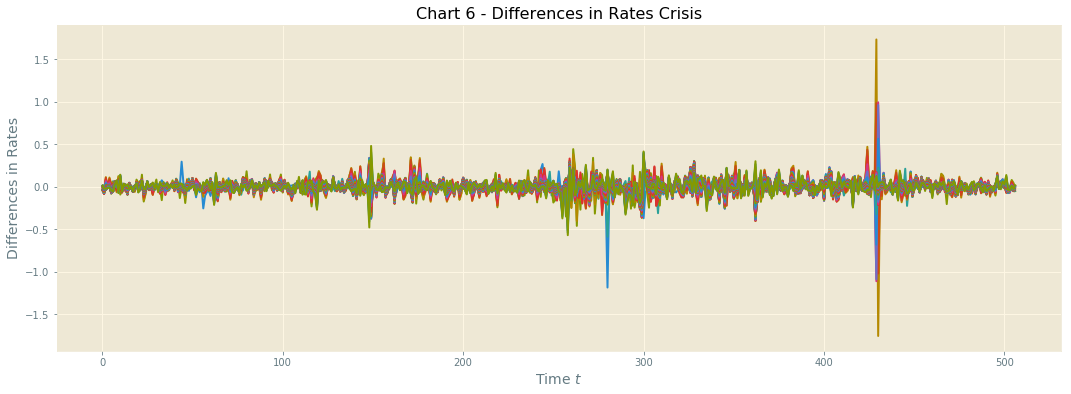

In [18]:
plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(diff_rates_recent*100,label=r'Log Differences in Rates - Recent Data - $log \, f(t + \Delta t) - logf(t)$ ')
    # Number of accent colors in the color scheme
    plt.title(r'Chart 5 - Log Differences in Rates Recent $log \, f(t + \Delta t) - logf(t)$ ')
    plt.xlabel(r'Time $t$', fontsize=14)
    plt.ylabel(r'Log Differences in Rates', fontsize=14)

plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(diff_rates_crisis*100,label=r'Differences in Rates - Crisis Data')
    # Number of accent colors in the color scheme
    plt.title(r'Chart 6 - Differences in Rates Crisis')
    plt.xlabel(r'Time $t$', fontsize=14)
    plt.ylabel(r'Differences in Rates', fontsize=14)

plt.show()

#### Covariance Matrix Decomposition
$\Sigma$ is the re-annualized covariance matrix of forward rates changes. Any symmetric matrix can be decomposed according to the spectral theorem:

$$\Sigma = \vee\wedge\vee'	$$

Where :

$\wedge$ = Diagonal matrix with **eigenvalues**

$\vee$ = is a Vectorized matrix of **eigenvectors**

For each eigenvector $e^{(i)}$, the first entry is the movement of the tenor 0.08, the second entry is related to the 0.5 Tenor and so on.
Our PCA will focus on the 3 main eigenvectors which are selected by the corresponding 3 largest eigenvalues. 

#### Factor Attribution
**Parallel shift** in overall level of rates is the largest principal component of forward curve movement, common to all tenors.

**Steepening/flattening** of the curve is the second important component. Inverted curve would have a different shape for the PC2.

**Bending about specific maturity points** is the third component to curve movement that mostly affects curvature (convexity).

Charts 7 and 8 represents the 3 PCA for each covariance matrix. 

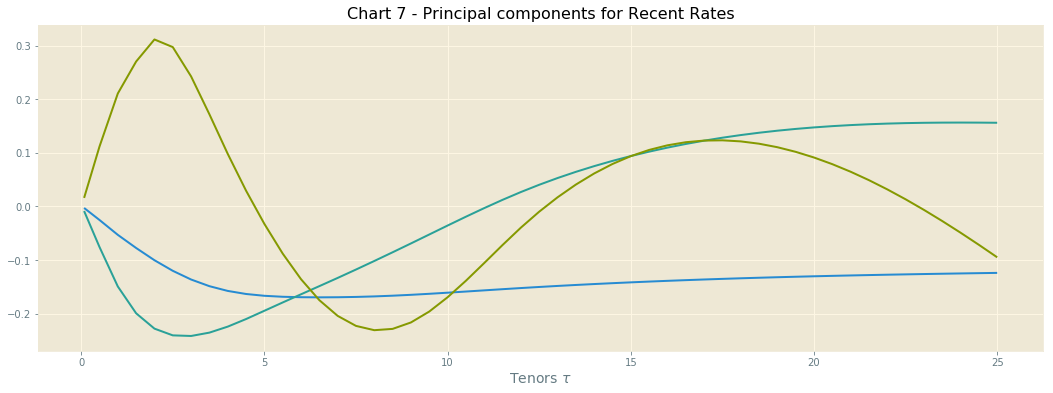

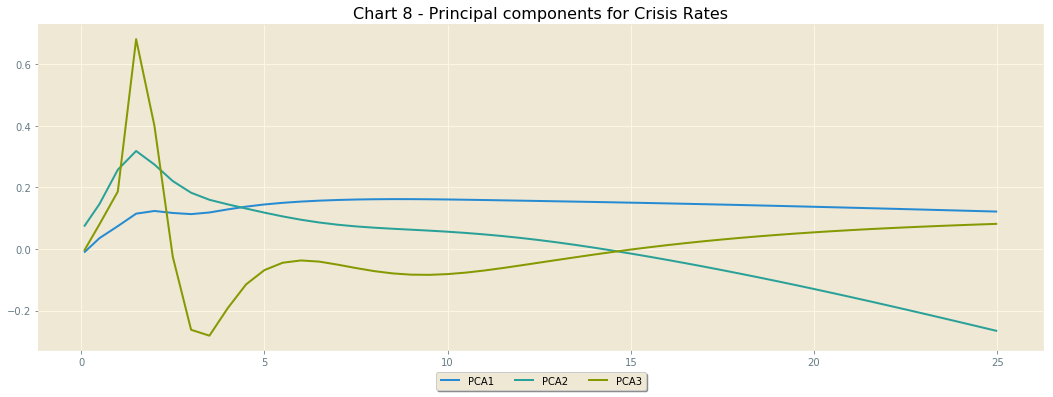

In [19]:
mc_tenors = np.array(tenors)

plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(tenors,princ_comp_recent[:,0])
    plt.plot(tenors,princ_comp_recent[:,1])
    plt.plot(tenors,princ_comp_recent[:,2])
    # Number of accent colors in the color scheme
    plt.title(r'Chart 7 - Principal components for Recent Rates')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    
plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(tenors,princ_comp_crisis[:,0],label=r'PCA1')
    plt.plot(tenors,princ_comp_crisis[:,1],label=r'PCA2')
    plt.plot(tenors,princ_comp_crisis[:,2],label=r'PCA3')
    # Number of accent colors in the color scheme
    plt.title(r'Chart 8 - Principal components for Crisis Rates')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)    
plt.show()

In [20]:
print("Principal eigenvalues recent data:")
print(princ_eigval_recent)
print("The 3 PCA explains :",str(round(sum(princ_eigval_recent.real)/sum(eigval_recent.real)*100,2)),'% of variation in the BLC curve\n')

print("Principal eigenvalues crisis data:")
print(princ_eigval_crisis)
print("The 3 PCA explains:",str(round(sum(princ_eigval_crisis.real)/sum(eigval_crisis.real)*100,2)),'% of variation in the BLC curve')

Principal eigenvalues recent data:
[  2.13769377e-03   1.07383656e-04   7.34959550e-05]
The 3 PCA explains : 96.89 % of variation in the BLC curve

Principal eigenvalues crisis data:
[ 0.00342655  0.00111086  0.00080282]
The 3 PCA explains: 78.75 % of variation in the BLC curve


Comparing both cumulative goodness of fit statistic for the k-factor model ($Cum. R^2$) we can conclude that the eigen-decomposition based on the recent data has a stronger predictive power. This is since the PCA analysis using the crisis dataset produces a higher uncertain attribution caused by a mix of higher rate period (Chart 4 - 2007/09 to 2008/12) and a regime of lower rates (Chart 4 - 2008/12 to the end).
Even though the Crisis dataset produces a poor PCA Component attribution we are going to continue the exercise in order to understand its impact on the final CVA calculation for the IRS.   

#### Obtain Volatilities Functions
Through calibration bc **PCA** and **fitting by cubic spline** the volatilities functions $\vee_i(t,\tau)$ and therefore, drift function  $m^-(t,\tau)$ are obtained. Both are functions of Tenors $\tau$.

HJM SDE applies at any point $f_j$ of the forward curve. We have a vector stochastic process.$$f(t,T) \Rightarrow \, f^{-}(t,T-t) =  f^{-}(t,\tau)$$

can be re-parametrized for tenor time $\tau_j = T_j - t$, index $j = 1 ... N$ refers to tenor 0.5Y, 1Y, ... etc.
The chart representation of discretized volatility functions for recent and crisis data are presented on Charts 9 and 10.

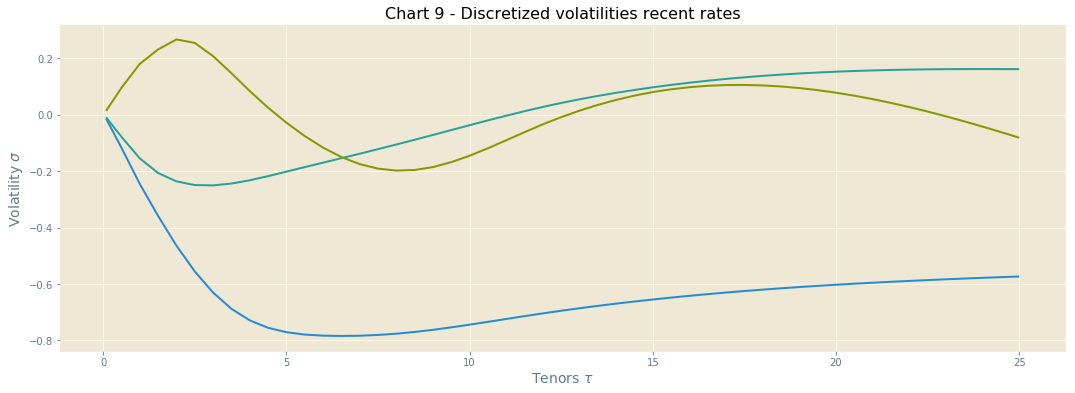

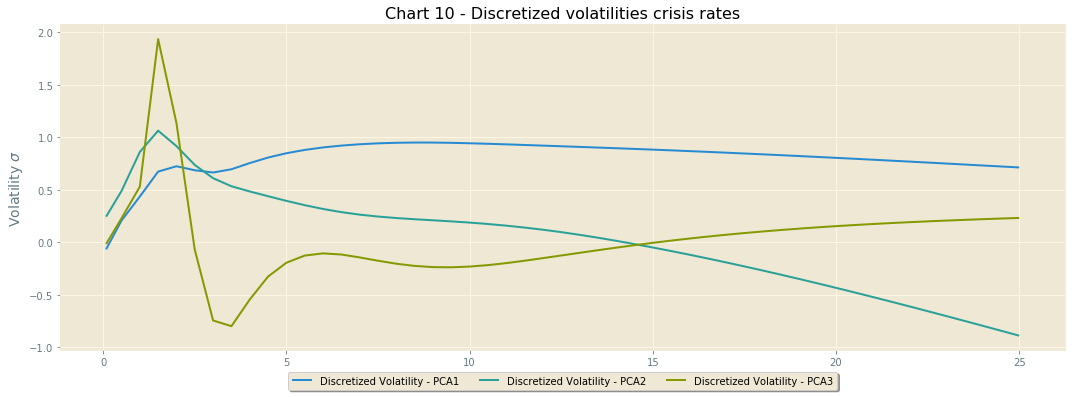

In [21]:
plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(tenors,vols_recent[:,0]*100)
    plt.plot(tenors,vols_recent[:,1]*100)
    plt.plot(tenors,vols_recent[:,2]*100)
    # Number of accent colors in the color scheme
    plt.title(r'Chart 9 - Discretized volatilities recent rates')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    plt.ylabel(r'Volatility $\sigma$', fontsize=14)
    
plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(tenors,vols_crisis[:,0]*100,label=r'Discretized Volatility - PCA1')
    plt.plot(tenors,vols_crisis[:,1]*100,label=r'Discretized Volatility - PCA2')
    plt.plot(tenors,vols_crisis[:,2]*100,label=r'Discretized Volatility - PCA3')
    # Number of accent colors in the color scheme
    plt.title(r'Chart 10 - Discretized volatilities crisis rates')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    plt.ylabel(r'Volatility $\sigma$', fontsize=14)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)    
plt.show()

#### Volatility Fitting
Fit Volatility Functions $\bar{v}(t,\tau)$ from discretized versions.

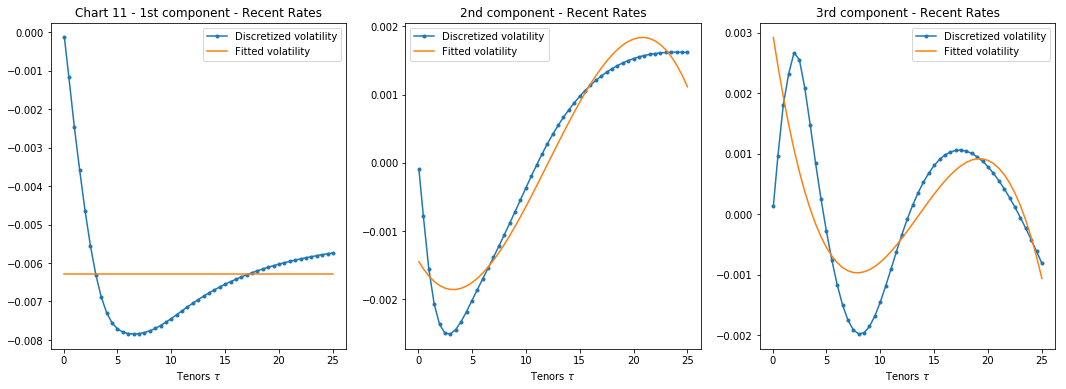

In [22]:
fitted_vols = []
def fit_volatility(i, degree, title):
    vol = get_matrix_column(vols_recent, i)
    fitted_vol = PolynomialInterpolator(np.polyfit(tenors, vol, degree))
    plt.plot(tenors, vol, marker='.', label='Discretized volatility')
    plt.plot(tenors, [fitted_vol.calc(x) for x in tenors], label='Fitted volatility')
    plt.title(title)
    plt.xlabel(r'Tenors $\tau$')
    plt.legend()
    fitted_vols.append(fitted_vol)
    
plt.figure(figsize=(18,6))    
plt.subplot(1, 3, 1), fit_volatility(0, 0, 'Chart 11 - 1st component - Recent Rates');
plt.subplot(1, 3, 2), fit_volatility(1, 3, '2nd component - Recent Rates');
plt.subplot(1, 3, 3), fit_volatility(2, 3, '3rd component - Recent Rates');

mc_tenors = np.linspace(0,25,51)
# Discretize fitted volfuncs for the purpose of monte carlo simulation
mc_vols_recent = np.matrix([[fitted_vol.calc(tenor) for tenor in mc_tenors] for fitted_vol in fitted_vols]).transpose()

mc_drift_recent = np.array([m(tau, fitted_vols) for tau in mc_tenors])

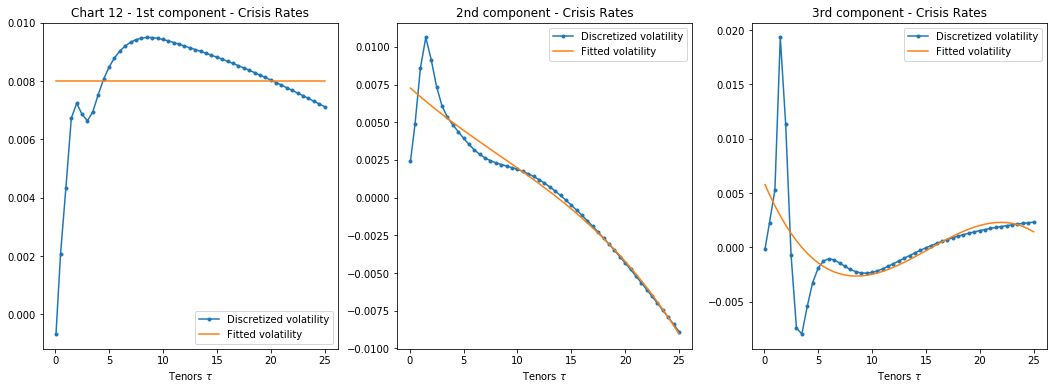

In [23]:
fitted_vols = []
def fit_volatility(i, degree, title):
    vol = get_matrix_column(vols_crisis, i)
    fitted_vol = PolynomialInterpolator(np.polyfit(tenors, vol, degree))
    plt.plot(tenors, vol, marker='.', label='Discretized volatility')
    plt.plot(tenors, [fitted_vol.calc(x) for x in tenors], label='Fitted volatility')
    plt.title(title)
    plt.xlabel(r'Tenors $\tau$')
    plt.legend()
    fitted_vols.append(fitted_vol)
    
plt.figure(figsize=(18,6))    
plt.subplot(1, 3, 1), fit_volatility(0, 0, 'Chart 12 - 1st component - Crisis Rates');
plt.subplot(1, 3, 2), fit_volatility(1, 3, '2nd component - Crisis Rates');
plt.subplot(1, 3, 3), fit_volatility(2, 3, '3rd component - Crisis Rates');

# Discretize fitted volfuncs for the purpose of monte carlo simulation
mc_vols_crisis = np.matrix([[fitted_vol.calc(tenor) for tenor in mc_tenors] for fitted_vol in fitted_vols]).transpose()

mc_drift_crisis = np.array([m(tau, fitted_vols) for tau in mc_tenors])

Drift calculation
Drift $m(t,\tau)$ is calculated using numerical integration over fitted volatility functions (No Mursiela parameterisation for now)

$$ m(t,\tau) = \sum_{i=1}^n v_i(t,\tau) \int_0^\tau v_i(t,s)ds $$

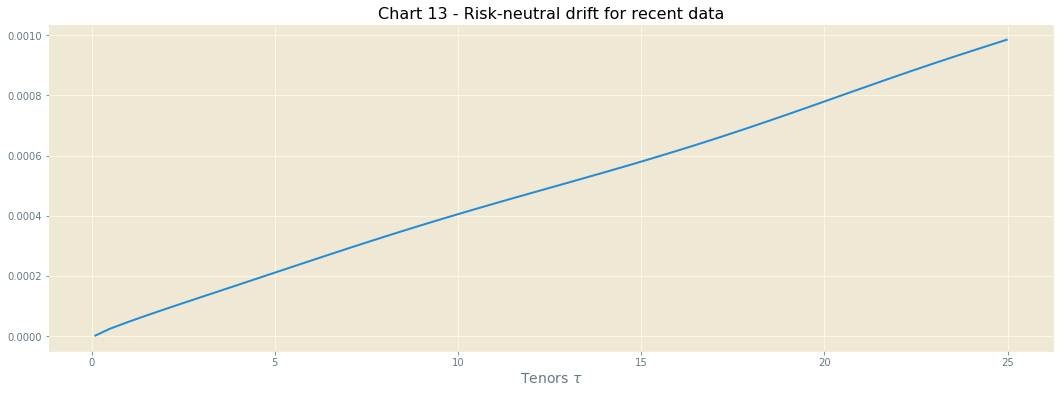

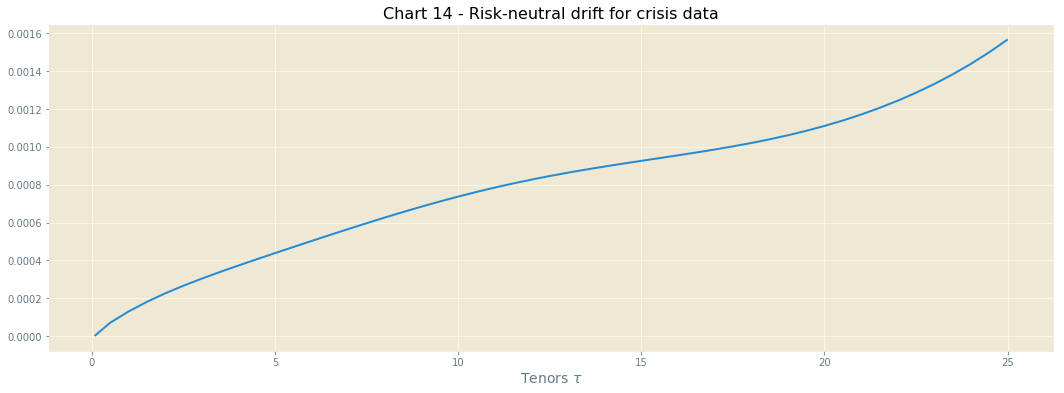

In [24]:
plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(tenors,mc_drift_recent)
    # Number of accent colors in the color scheme
    plt.title(r'Chart 13 - Risk-neutral drift for recent data')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    
plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(tenors,mc_drift_crisis)
    # Number of accent colors in the color scheme
    plt.title(r'Chart 14 - Risk-neutral drift for crisis data')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    
plt.show()

#### Monte Carlo Simulation
At this point we have all necessary elements to execute the Monte Carlo Simulation which will provide a set of forward rates which will be used to calculate the discount factors that will be used as input on the IRS price calculation and on the CVA charge of this contract. 

We simulate the instantaneous forward for $\tau_j$ for all tenors.
$$\bar{f}_{j}(t + dt) =\bar{f}_{j}(t) + d\bar{f}_{j}$$

Write the multi-factor HJM SDE (Musiela Parametrisation for $\tau$)
$$d\bar{f}_{j}(t,\tau) =\bar{m}(\tau)dt + \sum\limits_{i=1}^{k=3} \bar{\nu}_i(t,\tau)dX_i + \frac{\bar{f}(t,\tau)}{\partial \tau}dt$$

$$\bar{\nu}_i(t,\tau)dXi = \sqrt{\lambda_i}e^{i}_\tau \,\Phi_i \,\sqrt{\tau t}$$
The uncertainty around the k $\ll$ N linearly independent factors is simulated by the uncorrelated Brownian Motions $dX_i$ times volatility.

In [25]:
#Interest Rate Contract Specifications
pay_leg = 0.01425
maturity = 5
dt = 0.5
notional = 1000000
size = int(maturity/dt)

#Monte Carlo Data Preparation
tenors_irs = np.array(tenors)
tenors_irs = tenors_irs.reshape(51,1)
tenors_irs = tenors_irs.transpose()

vols_recent = mc_vols_recent.transpose()
drift_recent = np.matrix(mc_drift_recent)

vols_crisis = mc_vols_crisis.transpose()
drift_crisis = np.matrix(mc_drift_crisis)

row,col = tenors_irs.shape
tenors_dif = np.zeros(shape=(1,col))
tenors_dif[0,col-1]=dt
tenors_dif[0,:50]=tenors_irs[0:,1:]-tenors_irs[0:,:-1]

In [26]:
%%time
mc_sim_number = 1
total_years = 10
time_step = 0.01

projected_rates_recent = vector_mc_sim(tenors_dif,total_years,time_step,drift_recent,vols_recent)
projected_rates_crisis = vector_mc_sim(tenors_dif,total_years,time_step,drift_crisis,vols_crisis)

Wall time: 712 ms


#### Results from 1 Monte Carlos Simulation :

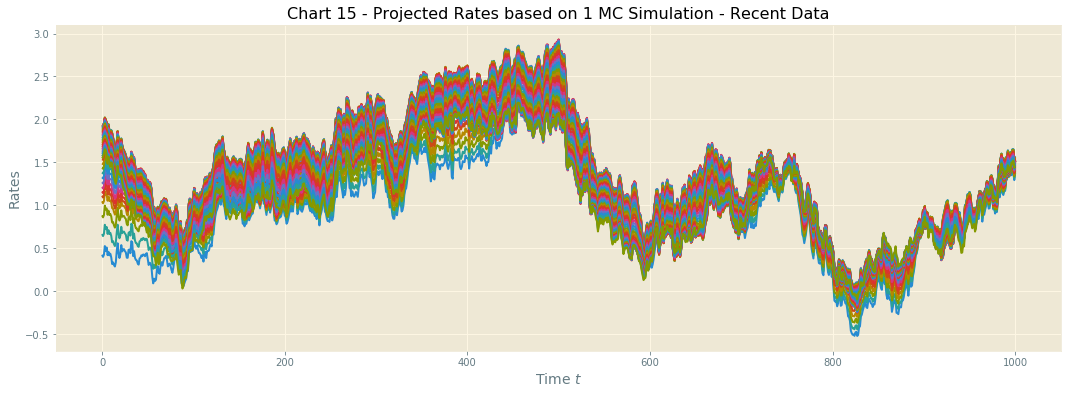

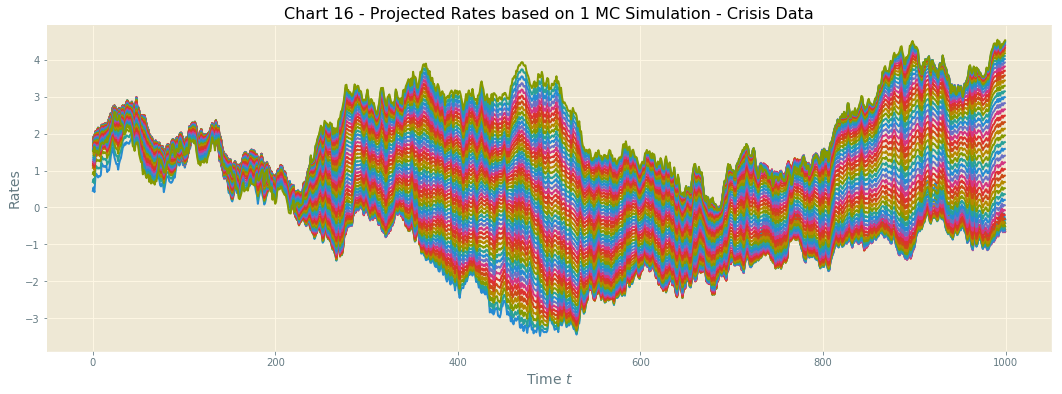

In [27]:
plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(projected_rates_recent*100)
    # Number of accent colors in the color scheme
    plt.title(r'Chart 15 - Projected Rates based on 1 MC Simulation - Recent Data')
    plt.xlabel(r'Time $t$', fontsize=14)
    plt.ylabel(r'Rates', fontsize=14)
    
plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(projected_rates_crisis*100)
    # Number of accent colors in the color scheme
    plt.title(r'Chart 16 - Projected Rates based on 1 MC Simulation - Crisis Data')
    plt.xlabel(r'Time $t$', fontsize=14)
    plt.ylabel(r'Rates', fontsize=14)

plt.show()

## Interest Rate Swap Contract Pricing
For this exercise the Interest Rate Swap (IRS) Contract  Specifications are :

pay_leg = 0.01425

maturity = 5

dt = 0.5

notional = 1000000

Since to calculate the Fair Value of the IRS we are using the last forward rate from the initial database. The price for IRS does not depend on the initial period of choice. For the most recent forward curve (chart 17) we can calculate the IRS Fair Value.

In [28]:
%%time
mc_sim_number = 1000
mc_results_recent = np.zeros(shape=(size+1,mc_sim_number))
mc_results_crisis = np.zeros(shape=(size+1,mc_sim_number))
total_years = 10
time_step = 0.01

for n in range(0,mc_sim_number):
    projected_rates_recent = vector_mc_sim(tenors_dif,total_years,time_step,drift_recent,vols_recent)
    projected_rates_crisis = vector_mc_sim(tenors_dif,total_years,time_step,drift_crisis,vols_crisis)
    irs_relevant_rates_recent = extract_relevant_tenors(projected_rates_recent,maturity,dt)
    irs_relevant_rates_crisis = extract_relevant_tenors(projected_rates_crisis,maturity,dt)
    discounted_projected_cashflows_recent = irs_exposure_profile(pay_leg,maturity,dt,notional,irs_relevant_rates_recent)
    discounted_projected_cashflows_crisis = irs_exposure_profile(pay_leg,maturity,dt,notional,irs_relevant_rates_crisis)
    exp_prof_recent = exposure_profiles(discounted_projected_cashflows_recent)
    exp_prof_crisis = exposure_profiles(discounted_projected_cashflows_crisis)
    mc_results_recent[:,n] = exp_prof_recent.transpose()
    mc_results_crisis[:,n] = exp_prof_crisis.transpose()

Wall time: 12min 2s


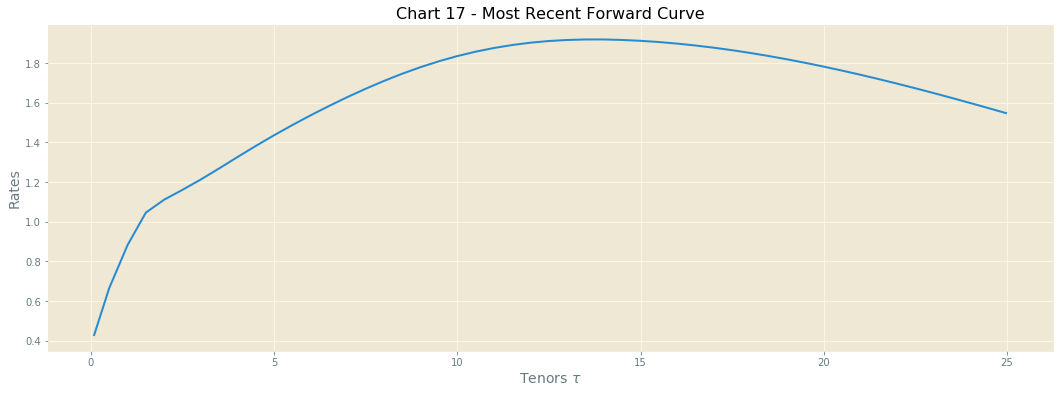

IRS Present Value is USD: 178.03


In [29]:
plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(tenors,curve_spot.transpose()*100)
    # Number of accent colors in the color scheme
    plt.title(r'Chart 17 - Most Recent Forward Curve')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    plt.ylabel(r'Rates', fontsize=14)

plt.show()

irs_price = round(mc_results_recent[0].mean(),2)
print("IRS Present Value is USD:",irs_price)

### CVA Calculation for IRS
#### Interest Rate Swap Expected Exposure

At this point are ready to use the HJM output for CVA calculation, the following example is based on 2 Monte Carlo runs of 1000 simulations each (one for recent data period and other for the crisis period).
Coming back to the CVA formula: $CVA = (1-R)\int_{0}^{T} EE_{t}\,DF_{t}\,dPD_{t}\,$

$EE_{t}$ is the Expected Exposure at time ${t}$ where $EE_t = E^{Q}[max(MTM,0]$, and we calculate it as average exposure for the 1000 simulations per Tenor $\tau$.

For the recent data the results are:

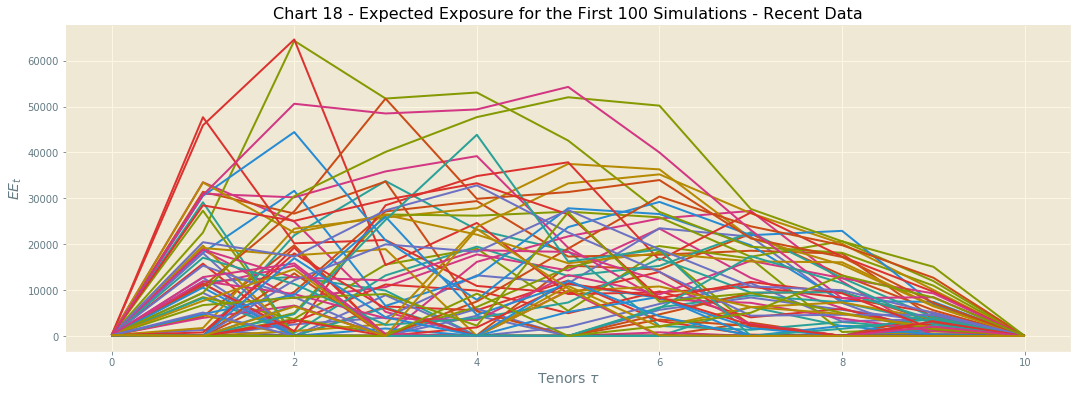

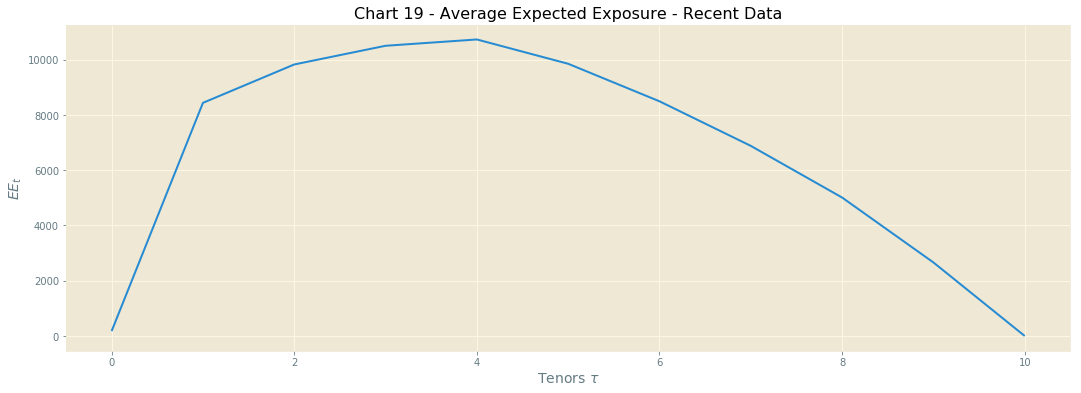

In [30]:
avg_exposures_recent = mc_results_recent.mean(axis=1)
avg_exposures_crisis = mc_results_crisis.mean(axis=1)

plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(mc_results_recent[:,:100])
    # Number of accent colors in the color scheme
    plt.title(r'Chart 18 - Expected Exposure for the First 100 Simulations - Recent Data')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    plt.ylabel(r'$EE_{t}$', fontsize=14)
    
plt.figure(figsize=(18,6))    
with plt.style.context('Solarize_Light2'):
    plt.plot(avg_exposures_recent)
    # Number of accent colors in the color scheme
    plt.title(r'Chart 19 - Average Expected Exposure - Recent Data')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    plt.ylabel(r'$EE_{t}$', fontsize=14)

plt.show()

For the crisis data the results are :

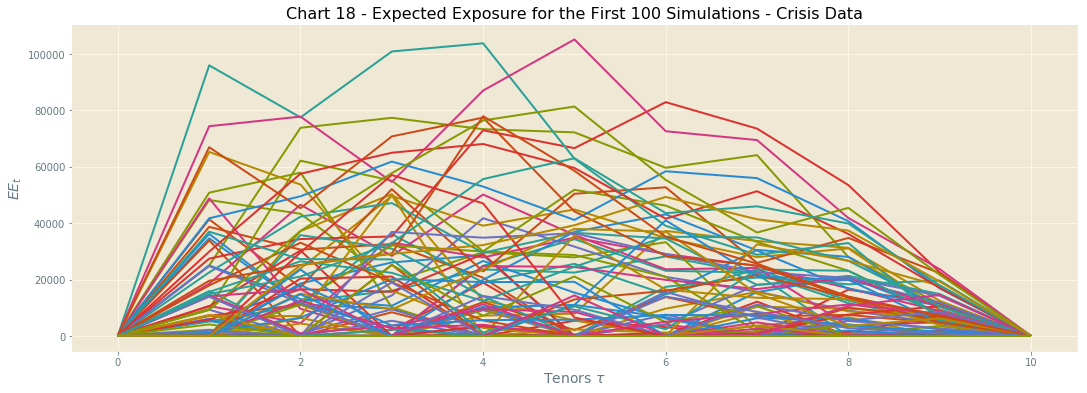

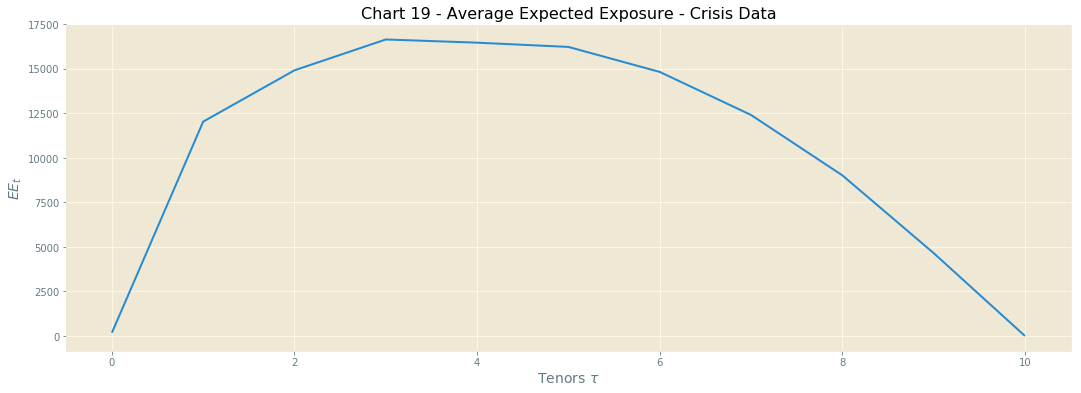

In [31]:
plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(mc_results_crisis[:,:100])
    # Number of accent colors in the color scheme
    plt.title(r'Chart 18 - Expected Exposure for the First 100 Simulations - Crisis Data')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    plt.ylabel(r'$EE_{t}$', fontsize=14)
    
plt.figure(figsize=(18,6))    
with plt.style.context('Solarize_Light2'):
    plt.plot(avg_exposures_crisis)
    # Number of accent colors in the color scheme
    plt.title(r'Chart 19 - Average Expected Exposure - Crisis Data')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    plt.ylabel(r'$EE_{t}$', fontsize=14)

plt.show()

In [32]:
print('Table 1 - Recent Rates Average Expected Exposure :')
display(round(pd.DataFrame(avg_exposures_recent).transpose(),0))
print('Table 2 - Crisis Rates Average Expected Exposure :')
display(round(pd.DataFrame(avg_exposures_crisis).transpose(),0))
print(r'Average Expected Exposure Crisis/Recent (%) :')
display(round(((pd.DataFrame(avg_exposures_crisis).transpose()/pd.DataFrame(avg_exposures_recent).transpose())-1)*100,2))

Table 1 - Recent Rates Average Expected Exposure :


,0,1,2,3,4,5,6,7,8,9,10
0,178.0,8440.0,9830.0,10507.0,10735.0,9855.0,8496.0,6883.0,5012.0,2662.0,0.0


Table 2 - Crisis Rates Average Expected Exposure :


,0,1,2,3,4,5,6,7,8,9,10
0,178.0,12039.0,14923.0,16655.0,16475.0,16236.0,14832.0,12414.0,9022.0,4655.0,0.0


Average Expected Exposure Crisis/Recent (%) :


,0,1,2,3,4,5,6,7,8,9,10
0,0.0,42.64,51.81,58.52,53.47,64.75,74.56,80.36,80.01,74.86,NaN


Comparing the 2 situations it is possible to see how the more volatile period for forward rates during the 2008 financial crisis reflects on 45% to 50% higher Expected Exposures $EE_{t}$ for the 2008 period.

#### Loss Given Default (LGD), Discount Factors ($DF_t$) and Default Probability ($dPD_t$) 

For the following example we will be assuming :

lambda_rate = 0.05

recovery_rate = 0.4

We will vectorize all variables in order to facilitate final calculations.
For Loss Given Default $LGD = (1-Recovery\, Rate)$ in vector format :

In [33]:
lambda_rate = 0.05
recovery_rate = 0.4

lgd_matrix = np.full((1, size), (1-recovery_rate))
display(pd.DataFrame(lgd_matrix))

,0,1,2,3,4,5,6,7,8,9
0,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6


Discount factors $DF_t$ are extracted from the most recent forward curve, we use the average between 2 discount factors :

In [34]:
last_rates = np.matrix(blc_curve_historical.tail(1))
last_rates=last_rates[:,1:]
disc_factors = disc_factors_matrix(fwd_rates_matrix(last_rates,dt),dt)
disc_factors=disc_factors[:,:size]

col0_avg = (disc_factors[:,0,None] + 1)/2
avg = (disc_factors[:,1:] + disc_factors[:,:-1])/2
avg_disc_factors = np.c_[col0_avg, avg]
avg_disc_factors

display(pd.DataFrame(avg_disc_factors))

,0,1,2,3,4,5,6,7,8,9
0,0.998342,0.993961,0.987857,0.981283,0.974786,0.967932,0.960546,0.952616,0.944219,0.935448


Default Probability formulas is $dPD_t = PD(t_{i-1},t_{i}) = P(0,t_{i-1})-P(0,t_i)$, in vector format :

In [35]:
col0_pd = np.array([[(1-np.exp(-lambda_rate*dt))]])
tenors_lambda = np.zeros(shape=(1,size))
tenors_lambda[:,:] = tenors[1:11]
pds = -(np.exp(-lambda_rate*tenors_lambda[:,1:])-np.exp(-lambda_rate*tenors_lambda[:,:-1]))
pd_matrix = np.c_[col0_pd, pds]
display(pd.DataFrame(pd_matrix))

,0,1,2,3,4,5,6,7,8,9
0,0.02469,0.02408,0.023486,0.022906,0.022341,0.021789,0.021251,0.020726,0.020215,0.019715


For Expected Exposure $EE_t$ we use the difference of $EE_t$ between 2 consecutive tenors :

In [36]:
diff_exposures_recent = np.zeros(shape=(1,size))
diff_exposures_recent = avg_exposures_recent[1:]-avg_exposures_recent[:-1]
diff_exposures_recent = diff_exposures_recent.reshape(10,1).transpose()

diff_exposures_crisis = np.zeros(shape=(1,size))
diff_exposures_crisis = avg_exposures_crisis[1:]-avg_exposures_crisis[:-1]
diff_exposures_crisis =diff_exposures_crisis.reshape(10,1).transpose()

print('Exposure Array for Recent Data :')
display(pd.DataFrame(diff_exposures_recent))

print('Exposure Array for Crisis Data :')
display(pd.DataFrame(diff_exposures_crisis))

Exposure Array for Recent Data :


,0,1,2,3,4,5,6,7,8,9
0,8262.145555,1389.867013,676.694348,228.388192,-880.44964,-1358.256529,-1613.867494,-1870.296072,-2350.028302,-2662.222568


Exposure Array for Crisis Data :


,0,1,2,3,4,5,6,7,8,9
0,11861.150611,2883.635794,1732.152004,-179.824044,-239.312135,-1404.207074,-2417.944162,-3391.283815,-4367.165661,-4655.227017


Using the $CVA = (1-R)\int_{0}^{T} EE_{t}\,DF_{t}\,dPD_{t}\,$ formula on with the arrays : 

In [37]:
cva_period_recent = diff_exposures_recent*avg_disc_factors*pd_matrix*lgd_matrix
cva_recent = round(cva_period_recent.sum(),2)

cva_period_crisis = diff_exposures_crisis*avg_disc_factors*pd_matrix*lgd_matrix
cva_crisis = round(cva_period_crisis.sum(),2)

print("IRS Present Value is USD:",irs_price,"\nCVA charge for Recent Dataset is :",cva_recent,"\nCVA charge for Crisis Dataset is :",cva_crisis )
print("IRS Final Price is for Recent DataSet is :",irs_price-cva_recent,"\nIRS Final Price is for Crisis DataSet is :",irs_price-cva_crisis)
print("CVA Charge using the 2008 Financial Crisis Forward Rate data as the initial input into the HJM model produces a ",round(((cva_crisis/cva_recent)-1)*100),"% higher CVA result")

IRS Present Value is USD: 178.03 
CVA charge for Recent Dataset is : 27.67 
CVA charge for Crisis Dataset is : 46.31
IRS Final Price is for Recent DataSet is : 150.36 
IRS Final Price is for Crisis DataSet is : 131.72
CVA Charge using the 2008 Financial Crisis Forward Rate data as the initial input into the HJM model produces a  67.0 % higher CVA result


Additionally using the output from the Monte Carlo Simulation, we can produce **Potential Future Exposures profiles (PFE)**, the following charts demonstrate PFE for both cases calculated as: Median of Positive Exposure (Chart 20 and 21) and as the 97.5% percentile (charts 22 and 23).

In [38]:
potential_future_exposure_recent = np.zeros(shape=(1,size+1))
potential_future_exposure_crisis = np.zeros(shape=(1,size+1))
for n in range(0,size+1):
    potential_future_exposure_recent[:,n] = np.median(mc_results_recent[n][mc_results_recent[n]>0])
potential_future_exposure_recent[:,10]=0

for n in range(0,size+1):
    potential_future_exposure_crisis[:,n] = np.median(mc_results_crisis[n][mc_results_crisis[n]>0])
potential_future_exposure_crisis[:,10]=0

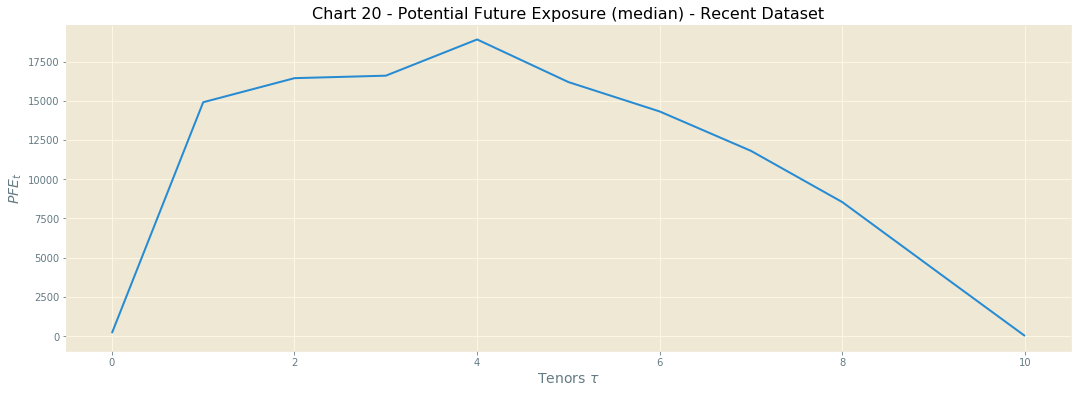

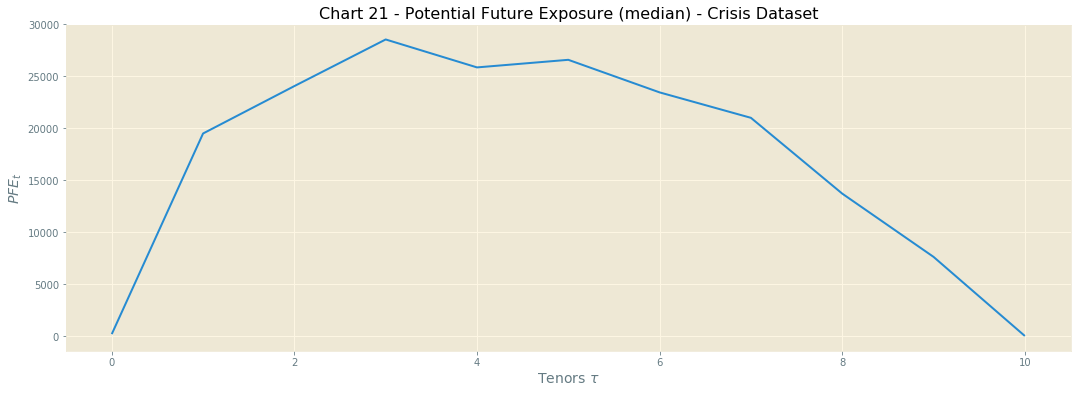

In [39]:
plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(potential_future_exposure_recent.transpose())
    # Number of accent colors in the color scheme
    plt.title(r'Chart 20 - Potential Future Exposure (median) - Recent Dataset')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    plt.ylabel(r'$PFE_{t}$', fontsize=14)
    
plt.figure(figsize=(18,6))    
with plt.style.context('Solarize_Light2'):
    plt.plot(potential_future_exposure_crisis.transpose())
    # Number of accent colors in the color scheme
    plt.title(r'Chart 21 - Potential Future Exposure (median) - Crisis Dataset')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    plt.ylabel(r'$PFE_{t}$', fontsize=14)

plt.show()

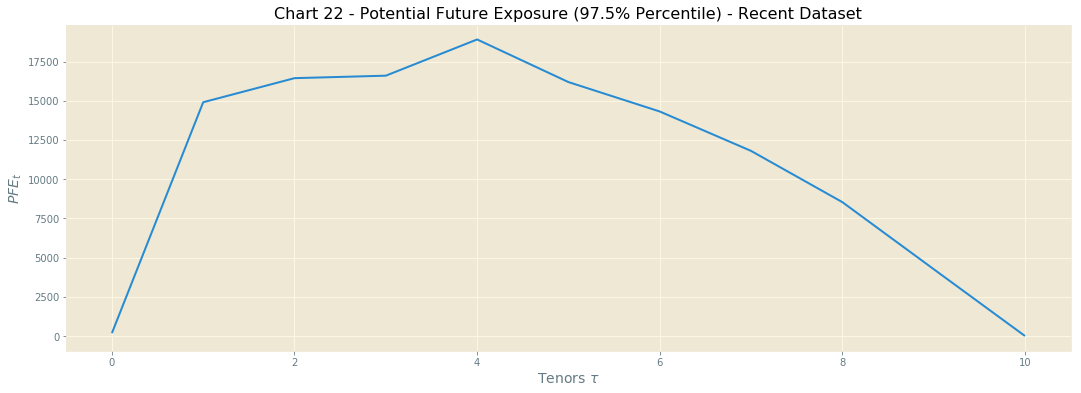

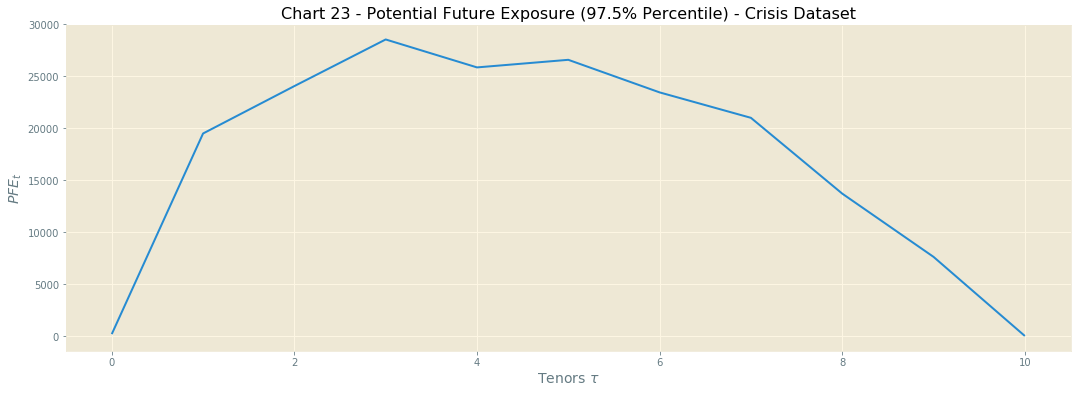

In [40]:
percentil_975_recent = np.percentile(mc_results_recent,97.5,axis=1)
percentil_975_crisis = np.percentile(mc_results_crisis,97.5,axis=1)

plt.figure(figsize=(18,6))
with plt.style.context('Solarize_Light2'):
    plt.plot(potential_future_exposure_recent.transpose())
    # Number of accent colors in the color scheme
    plt.title(r'Chart 22 - Potential Future Exposure (97.5% Percentile) - Recent Dataset')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    plt.ylabel(r'$PFE_{t}$', fontsize=14)
    
plt.figure(figsize=(18,6))    
with plt.style.context('Solarize_Light2'):
    plt.plot(potential_future_exposure_crisis.transpose())
    # Number of accent colors in the color scheme
    plt.title(r'Chart 23 - Potential Future Exposure (97.5% Percentile) - Crisis Dataset')
    plt.xlabel(r'Tenors $\tau$', fontsize=14)
    plt.ylabel(r'$PFE_{t}$', fontsize=14)

plt.show()

### Conclusion

Comparing both results the turbulent and highly volatile rates regime of the financial crisis reflects in a considerably higher (52%) CVA when compared with the recent rates regime implementation but as expected it produces a lower quality principal components analysis ,$Cum. R^2$ for the second case is 78.75% compared with a 96.98% fit for the recent data case, given the unclear attribution which can be observed in chart 12 (PCA components do not match their roles (parallel shift, skew and twist) of the curve).